<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/ODR_2024_1_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [ODE Based Models in Stan](https://mc-stan.org/events/stancon2017-notebooks/stancon2017-margossian-gillespie-ode.html)

#### [Example: simple harmonic oscillator](https://mc-stan.org/docs/stan-users-guide/example-simple-harmonic-oscillator.html#example-simple-harmonic-oscillator)

#### [Bayesian workflow for disease transmission modeling in Stan](https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html)

#### [ Ordinary differential equation (ODE) solvers](https://mc-stan.org/docs/functions-reference/functions-ode-solver.html#functions-ode-solver)


In [22]:
install.packages('outbreaks')

Installing package into ‘/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [1]:
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘Rcpp’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’




In [1]:
library(rstan)
library(gridExtra)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
parallel::detectCores()

[1] 8

In [3]:
example(stan_model, package = "rstan", run.dontrun = TRUE)


stn_md> stancode <- 'data {real y_mean;} parameters {real y;} model {y ~ normal(y_mean,1);}'

stn_md> mod <- stan_model(model_code = stancode, verbose = TRUE)

TRANSLATING MODEL '' FROM Stan CODE TO C++ CODE NOW.
OS: x86_64, linux-gnu; rstan: 2.32.5; Rcpp: 1.0.11; inline: 0.3.19 
 >> setting environment variables: 
PKG_LIBS =  '/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/rstan/lib//libStanServices.a' -L'/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/StanHeaders/lib/' -lStanHeaders -L'/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/RcppParallel/lib/' -ltbb 
PKG_CPPFLAGS =   -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/Rcpp/include/"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/RcppEigen/include/"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/RcppEigen/include/unsupported"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/BH/include" -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/StanHeaders/include/src/"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-lib



---



In [4]:
library(outbreaks)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.3     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.3
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


In [5]:
head(influenza_england_1978_school)

,date,in_bed,convalescent
,<date>,<int>,<int>
1,1978-01-22,3,0
2,1978-01-23,8,0
3,1978-01-24,26,0
4,1978-01-25,76,0
5,1978-01-26,225,9
6,1978-01-27,298,17


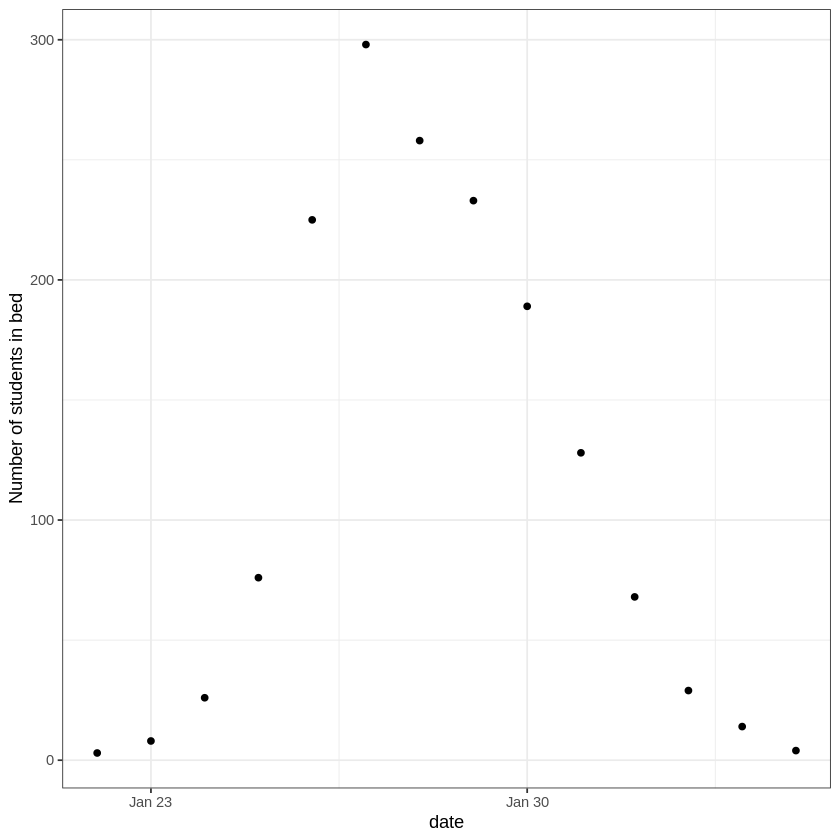

In [6]:
theme_set(theme_bw())
ggplot(data = influenza_england_1978_school) +
  geom_point(mapping = aes(x = date, y = in_bed)) +
  labs(y = "Number of students in bed")

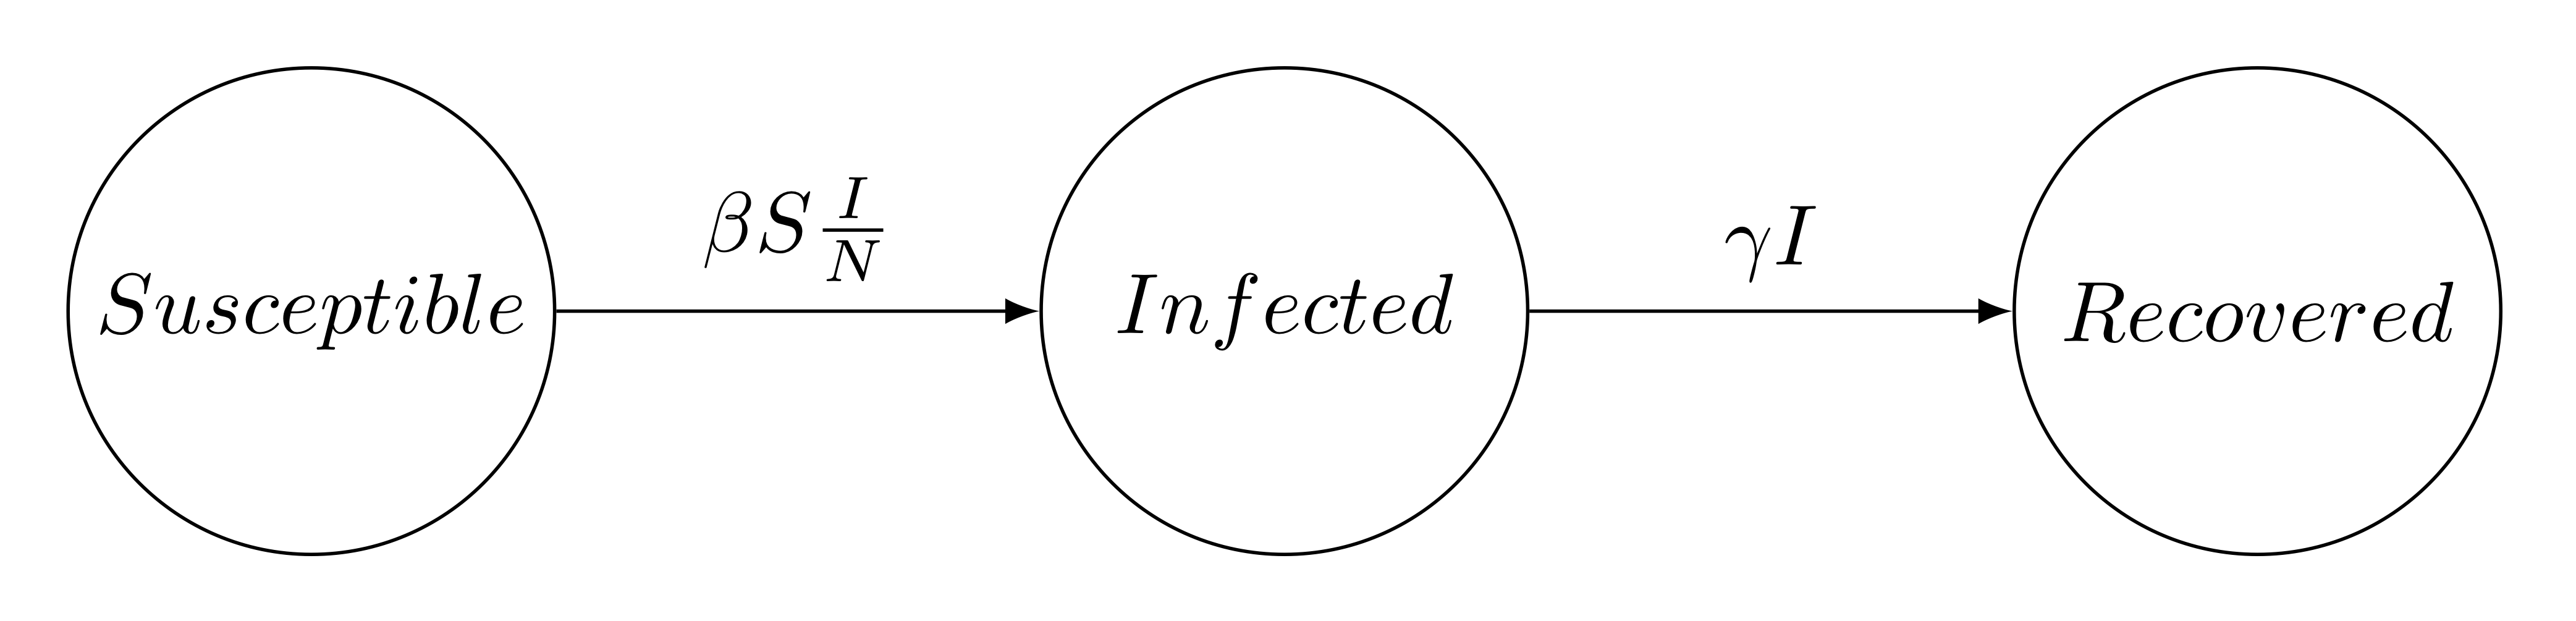

\begin{aligned}
 \frac{dS}{dt} &= -\beta  S \frac{I}{N}\\
 \frac{dI}{dt} &= \beta  S  \frac{I}{N} - \gamma  I \\
 \frac{dR}{dt} &= \gamma I
\end{aligned}


S(t)
 is the number of people susceptible to becoming infected (no immunity),

I(t)
 is the number of people currently infected (and infectious),

R(t)
 is the number of recovered people (we assume they remain immune indefinitely),

β
 is the constant rate of infectious contact between people,

γ
 the constant recovery rate of infected individuals.

In case of boarding school data, the spread of the disease has started with one infected individual which leads to the initial conditions I(0)=1,S(0)=N−1,R(0)=0.

#### The negative binomial distribution is a probability distribution that models the number of failures before a specified number of successes occur in a sequence of independent Bernoulli trials. It is a two-parameter distribution, with the first parameter representing the number of failures and the second parameter representing the probability of success in each trial.

In [7]:
model <- stan_model("./sir_ode.stan")

In [8]:
dim(influenza_england_1978_school)

[1] 14  3

In [9]:
# time series of cases
cases <- influenza_england_1978_school$in_bed  # Number of students in bed

# total count
N <- 763;

# times
n_days <- length(cases)
t <- seq(0, n_days, by = 1)
t0 = 0
t <- t[-1]

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

# data for Stan
data_sir <- list(n_days = n_days,
                    y0 = y0,
                    t0 = t0,
                    ts = t,
                    N = N,
                    cases = cases,
                    compute_likelihood=1
                )

# number of MCMC steps
niter <- 2000

In [10]:
t

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14

In [11]:
fit_sir_negbin <- sampling(model,
                data = data_sir,
                iter = niter,
                chains = 4,
                seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000181 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.81 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.974 seconds (Warm-up)
Chain 1:                2.649 seconds (Sampling)
Chain 1:                5.6

In [12]:
pars=c('beta', 'gamma', "R0", "recovery_time")

In [13]:
print(fit_sir_negbin, pars = pars)

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta          1.73    0.00 0.05 1.64 1.70 1.73 1.77  1.85  2529    1
gamma         0.54    0.00 0.05 0.46 0.51 0.54 0.57  0.64  2454    1
R0            3.21    0.01 0.27 2.73 3.03 3.19 3.37  3.83  2516    1
recovery_time 1.85    0.00 0.15 1.56 1.75 1.84 1.95  2.18  2495    1

Samples were drawn using NUTS(diag_e) at Sat Jan 27 08:58:13 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


'pars' not specified. Showing first 10 parameters by default.



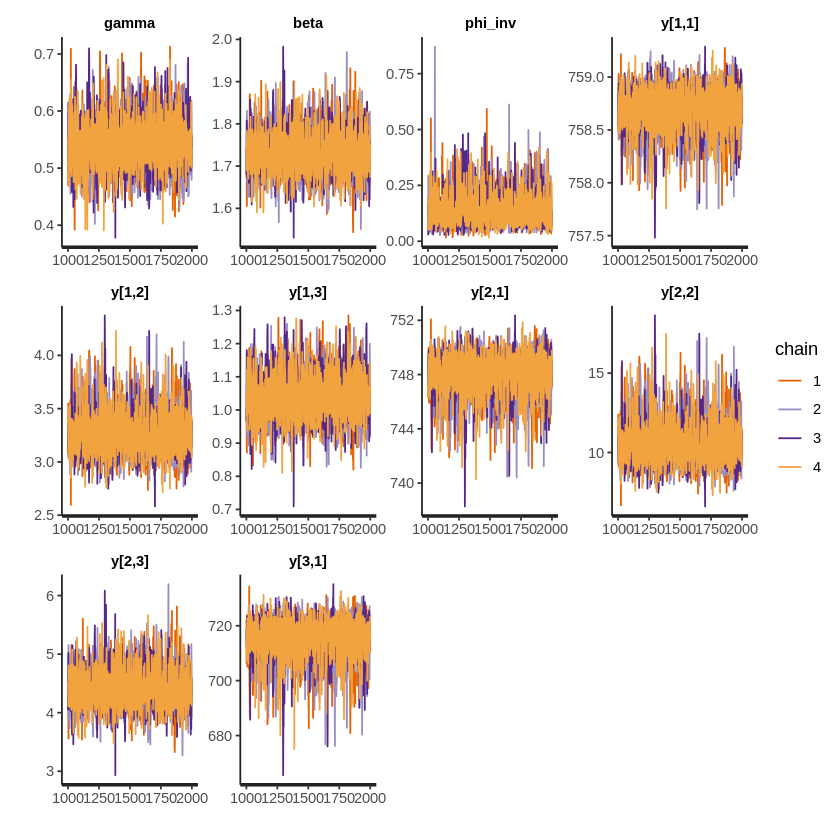

In [14]:
traceplot(fit_sir_negbin)

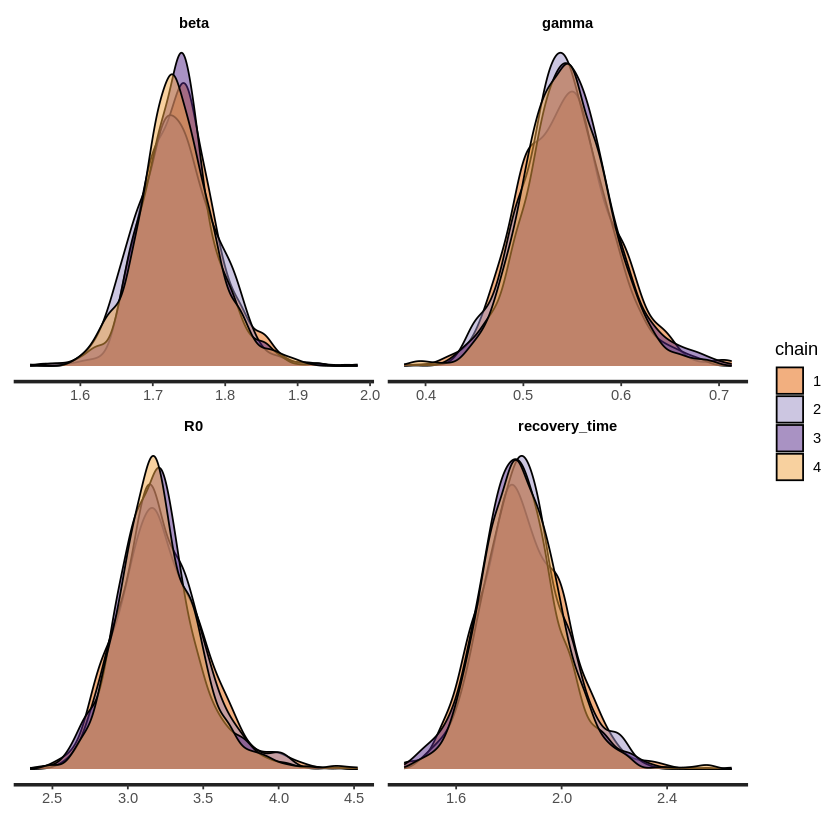

In [15]:
stan_dens(fit_sir_negbin, pars = pars, separate_chains = TRUE)

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



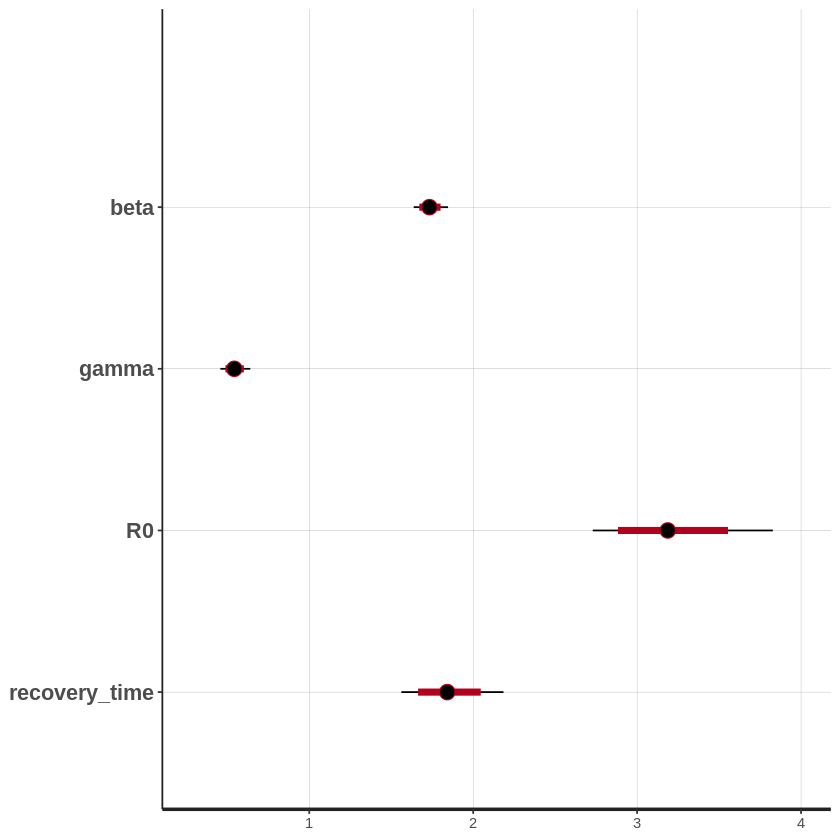

In [16]:
stan_plot(fit_sir_negbin,pars = pars)

### In general, it is good to check if our model, once fitted, produces simulations that are consistent with the observed data. This is the idea behind posterior predictive checks.

In [17]:
smr_pred <- cbind(as.data.frame(summary(
  fit_sir_negbin, pars = "pred_cases", probs = c(0.05, 0.5, 0.95))$summary), t, cases)
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

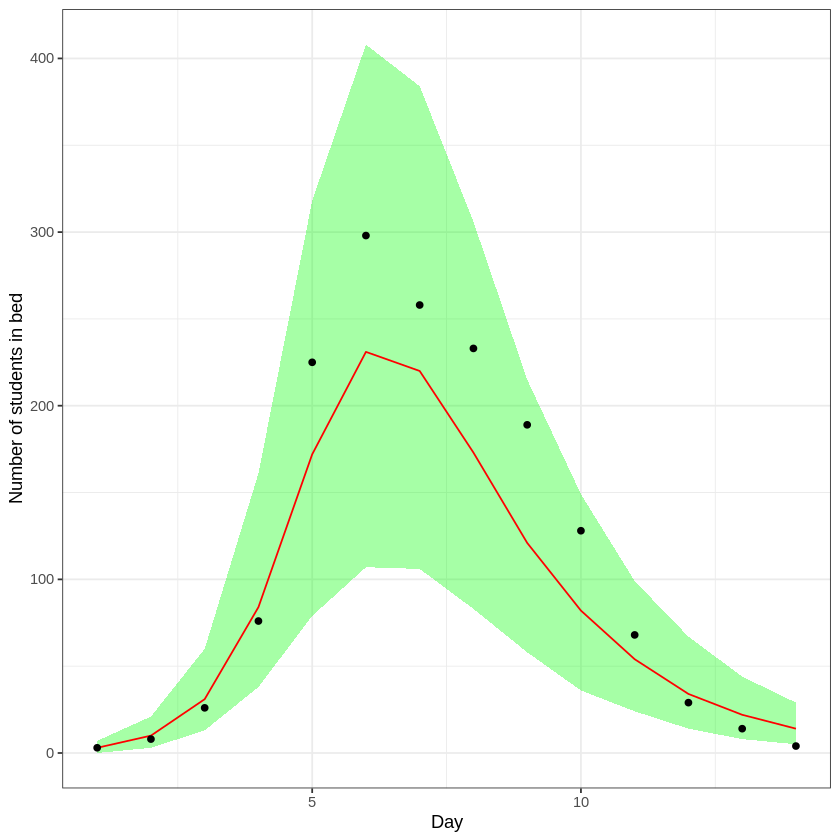

In [18]:
ggplot(smr_pred, mapping = aes(x = t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = "green", alpha = 0.35) +
  geom_line(mapping = aes(x = t, y = X50.), color = "red") + 
  geom_point(mapping = aes(y = cases)) +
  labs(x = "Day", y = "Number of students in bed")

# PPC


#### To conduct a **prior predictive check**, we take the same model as before, put the parameters of interest in the generated_quantities code block, and remove the sampling distribution term from the model. Without the sampling distribution, the parameters are not fitted to the data and are thus sampled from their prior distribution. The Stan code is thus the same as the final Stan code, without the cases ~ neg_binomial_2(col(to_matrix(y), 2), phi); line. A useful trick to make prior predictive check easy is to add a switch compute_likelihood to the data. Then in the model code block :

In [19]:
data_sir_ppc <- list(n_days = n_days,
                    y0 = y0,
                    t0 = t0,
                    ts = t,
                    N = N,
                    cases = cases,
                    compute_likelihood=0
                )


In [20]:
fit_sir_ppc <- sampling(model,
                data = data_sir_ppc,
                iter = niter,
                chains = 4,
                seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000173 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.73 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 25.128 seconds (Warm-up)
Chain 1:                3.385 seconds (Sampling)
Chain 1:                28

In [21]:
s_prior <- rstan::extract(fit_sir_ppc)

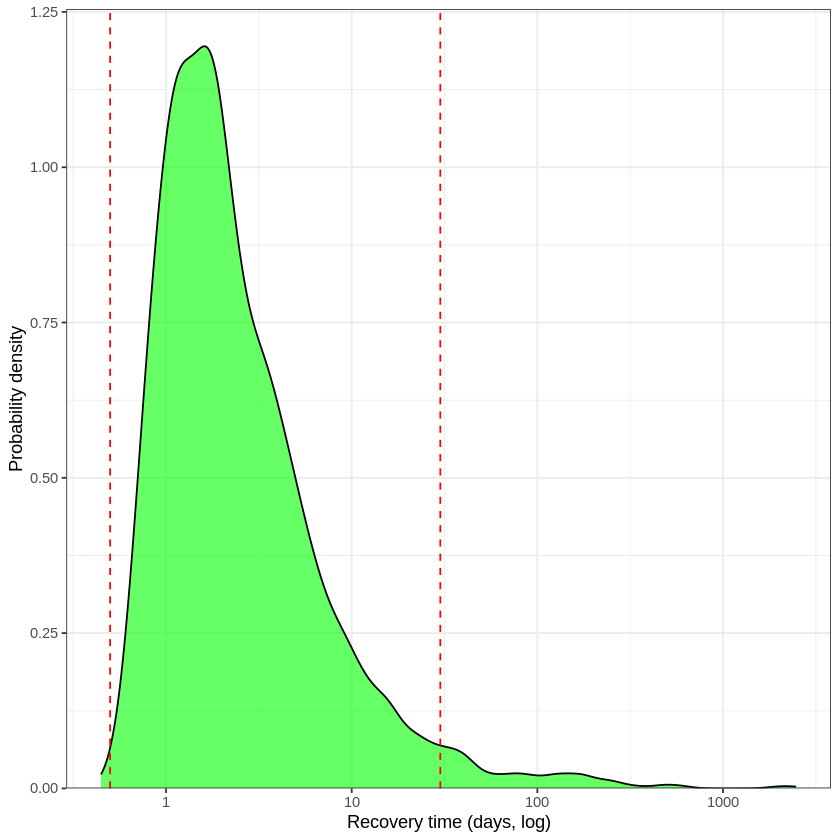

In [22]:
ggplot(tibble(r = s_prior$recovery_time)) + 
  geom_density(aes(x = r),fill="green", alpha = 0.6) + 
  geom_vline(xintercept = c(0.5,30), color = "red",linetype=2) + 
  scale_x_log10() +
  scale_y_continuous(expand=expansion(c(0,.05))) +
  labs(x="Recovery time (days, log)",y="Probability density")

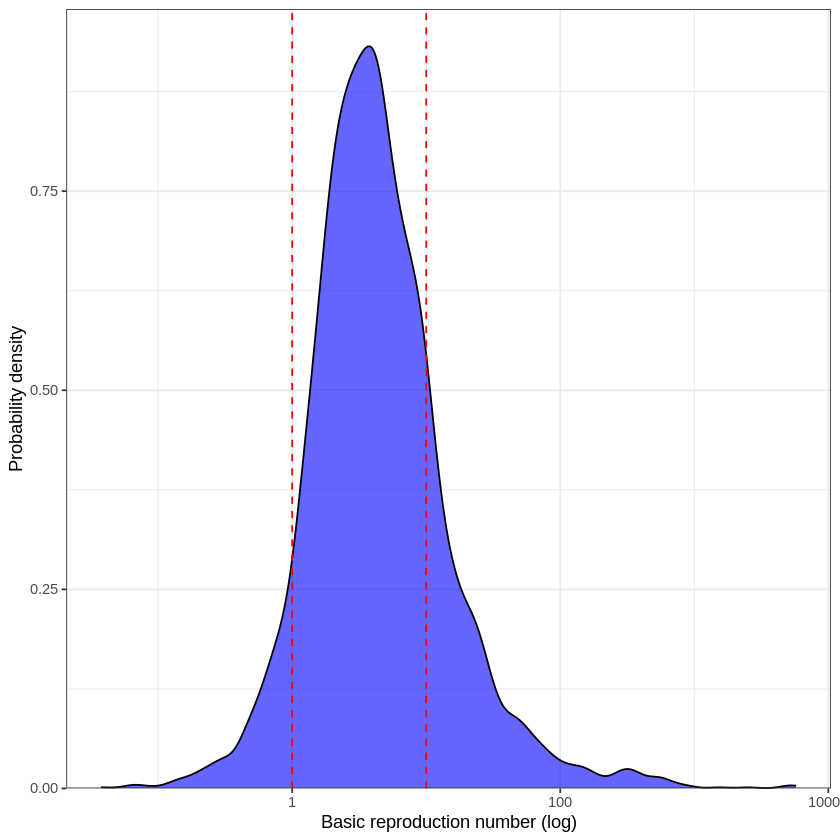

In [23]:
ggplot(tibble(r = s_prior$R0)) + 
  geom_density(aes(x = r),fill="blue", alpha = 0.6) + 
  geom_vline(xintercept = c(1,10), color = "red",linetype=2) + 
  scale_x_log10() +
  scale_y_continuous(expand=expansion(c(0,.05))) +
  labs(x="Basic reproduction number (log)",y="Probability density")

In [24]:
dim(s_prior$y)

[1] 4000   14    3

#### We can also plot trajectories of infection according to the prior, that is the number of infected people at each time accoring to prior distributions of parameters.

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


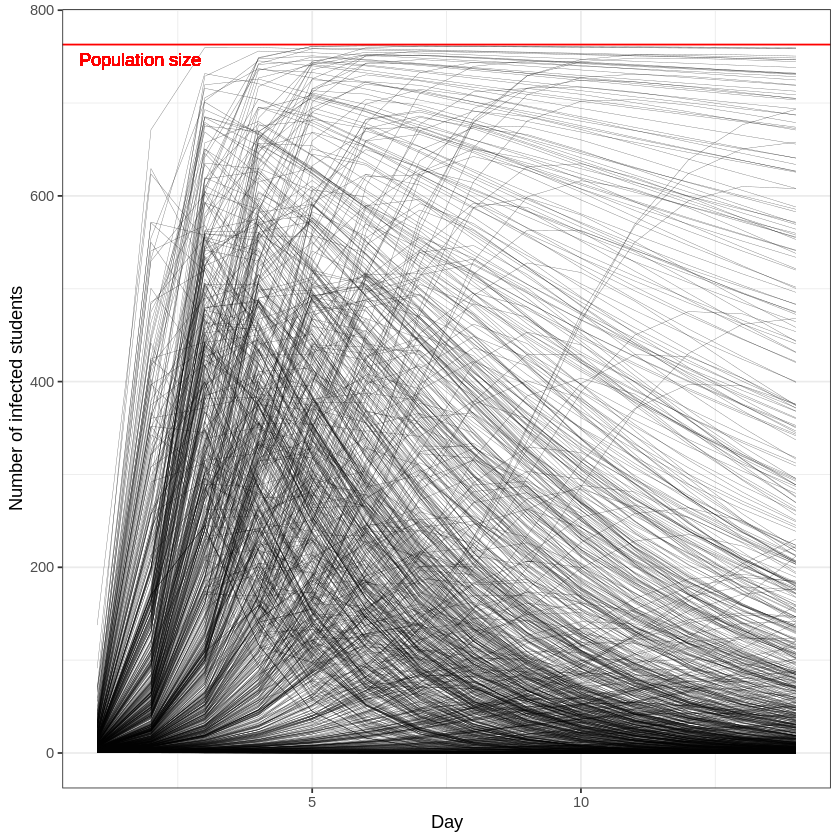

In [25]:
n_draws <- 1000
draws <- as_tibble(t(s_prior$y[,,2][1:n_draws,])) %>% add_column(t=t)
draws <-  pivot_longer(draws, c(1:1000) , names_to = "draw")
draws %>% 
  ggplot() + 
  geom_line(mapping = aes(x = t, y=value, group = draw), alpha = 0.6, linewidth=0.1) +
  geom_hline(yintercept=763, color="red")  +
  geom_text(x=1.8, y=747, label="Population size", color="red") +
  labs(x = "Day", y="Number of infected students")

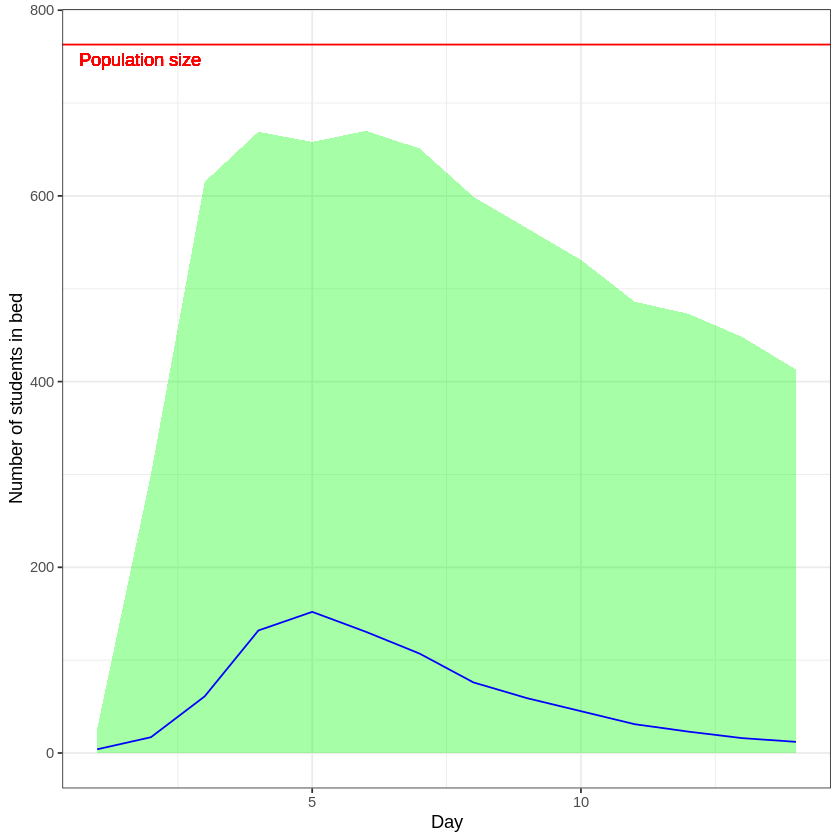

In [30]:
smr_pred <- cbind(as.data.frame(summary(fit_sir_ppc, pars="pred_cases", 
                                        probs=c(0.05, 0.5, 0.95))$summary), t)
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

ggplot(smr_pred, mapping=aes(x=t)) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = "green", alpha = 0.35) +
  geom_line(mapping=aes(x=t, y=X50.), color = "blue") + 
  geom_hline(yintercept=763, color="red" ) +
  geom_text(x=1.8, y=747, label="Population size", color="red") +
  labs(x = "Day", y="Number of students in bed")

#### It seems that most trajectories are reasonable and quite diverse. Still, some of the curves look a little bit funky and suggest we could refine our priors and make them more informative, although it may not be needed here.

#### Typically, we can get away with priors that do not capture all our a priori knowledge, provided the data is informative enough. However when dealing with complicated models and relatively sparse data, we usually need well constructed priors to regularize our estimates and avoid non-identifiability.

In [31]:
# one arbitrary draw from the prior distribution
draw <- 12 
# the number of predicted cases sampled from the prior distribution, which we will use as data
cases_simu <- s_prior$pred_cases[draw,] 

In [32]:
cases_simu

[1]  10  12  75 105  92 695 325 237 358 315 234 236 325 123

In [33]:
data_simu <-  list (n_days  = n_days, y0 = y0, t0 = t0, ts = t, N=N, cases=cases_simu, compute_likelihood=1)
fit_simu <- sampling(model, 
                     data=data_simu, 
                     chains=4,
                     seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000299 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 2.99 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.897 seconds (Warm-up)
Chain 1:                2.554 seconds (Sampling)
Chain 1:                5.4

In [34]:
params = c("beta", "gamma", "phi")
paste("true beta :", toString(s_prior$beta[draw]), 
      ", true gamma :", toString(s_prior$gamma[draw]), ", true phi :", toString(s_prior$phi[draw]))

[1] "true beta : 1.52773106497054 , true gamma : 0.161678631233603 , true phi : 5.54943720829349"

In [35]:
print(fit_simu, pars = params)

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta  1.53    0.00 0.13 1.33 1.44 1.51 1.60  1.82  2075    1
gamma 0.17    0.00 0.03 0.10 0.15 0.17 0.19  0.24  1139    1
phi   4.45    0.04 1.72 1.91 3.18 4.19 5.40  8.46  2373    1

Samples were drawn using NUTS(diag_e) at Sat Jan 27 09:14:51 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [37]:
c_simu= "green"

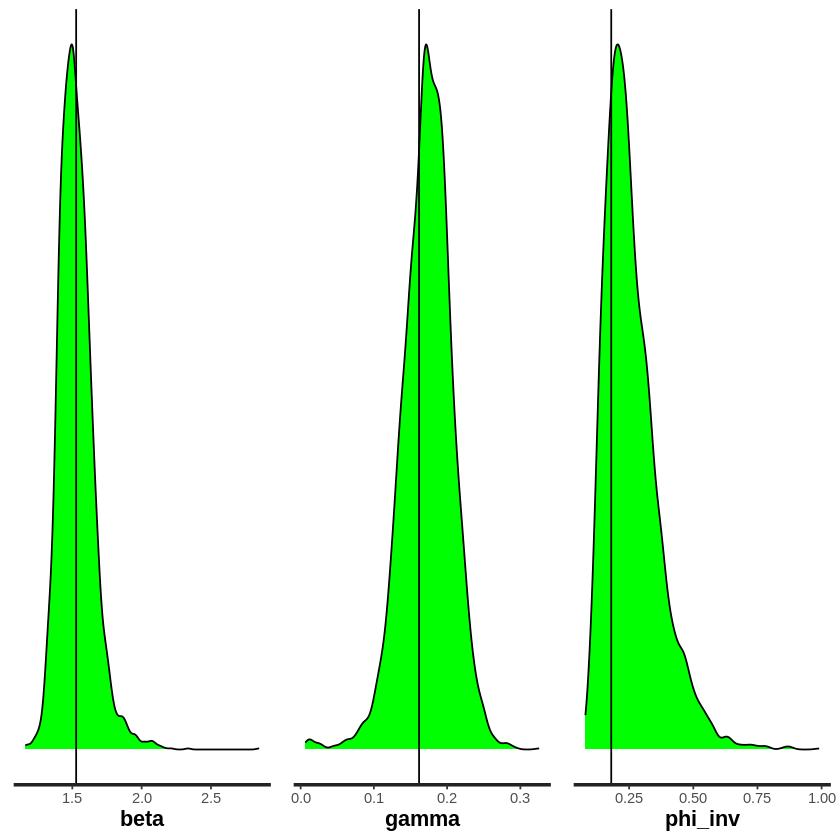

In [38]:
plot_beta <- stan_dens(fit_simu, pars="beta", fill = c_simu) + geom_vline(xintercept =s_prior$beta[draw])
plot_gamma <- stan_dens(fit_simu, pars="gamma", fill = c_simu) + geom_vline(xintercept = s_prior$gamma[draw])
plot_phi <- stan_dens(fit_simu, pars="phi_inv", fill = c_simu) + geom_vline(xintercept = s_prior$phi_inv[draw])
grid.arrange(plot_beta, plot_gamma, plot_phi, nrow=1)

## Scaling up ODE-based models

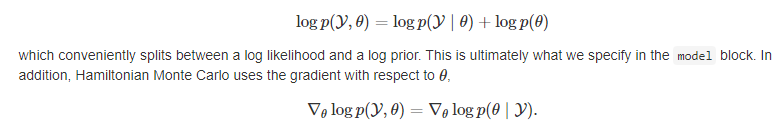

## COVID-19 transmission in Switzerland

#### To illustrate the ideas presented in this tutorial, we are going to tackle a more complex example: COVID-19 transmission in Switzerland during the period from February 2020 to June 2020. We’ll see that in this more complicated setting, sampling from the posterior distribution can be difficult, and we’ll need to rely on Stan’s diagnostics to check that our inference is reliable.